This installs and imports the required Python libraries for fine-tuning a transformer-based language model.
I use Hugging Face Transformers for loading the pre-trained BERT model and tokenizer, Datasets for accessing the 20 Newsgroups dataset, PyTorch for model training, and Scikit-learn for evaluation metrics.

In [1]:
!pip install -q transformers datasets torch scikit-learn


In [2]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    get_scheduler
)
# import for AdamW
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cuda
GPU: NVIDIA L4


This loads the 20 Newsgroups dataset from a maintained Hugging Face repository.
The dataset contains forum-style documents categorised into 20 topical classes and is split into training and test sets.

In [4]:
# Load the 20 Newsgroups dataset
dataset = load_dataset("SetFit/20_newsgroups")

# Inspect dataset structure
dataset



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/734 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/8.91M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11314 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7532 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 11314
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 7532
    })
})

### Inspecting Dataset Structure

This cell displays the structure of the dataset, including available splits, feature names, and the number of samples in each split.  
This helps verify that the dataset is loaded correctly.


In [5]:
from collections import Counter

def compute_label_distribution(dataset_split):
    """
    Computes the frequency of each class label in a dataset split.
    This helps identify class imbalance before model training.
    """
    labels = dataset_split["label"]
    label_counts = Counter(labels)
    return label_counts


# Compute label distribution for training data
train_label_counts = compute_label_distribution(dataset["train"])
train_label_counts


Counter({7: 594,
         4: 578,
         1: 584,
         14: 593,
         16: 546,
         13: 594,
         3: 590,
         2: 591,
         8: 598,
         19: 377,
         6: 585,
         0: 480,
         12: 591,
         5: 593,
         10: 600,
         9: 597,
         15: 599,
         17: 564,
         18: 465,
         11: 595})

In [6]:
# Display one full example from the training set
sample = dataset["train"][0]

print("Text:\n")
print(sample["text"][:1000])  # show first 1000 characters

print("\nNumeric Label:", sample["label"])
print("Topic Name:", sample["label_text"])


Text:

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Numeric Label: 7
Topic Name: rec.autos


### Viewing Examples from Different Classes

This cell displays sample text snippets from multiple distinct classes.  
The goal is to qualitatively examine differences between topics in the dataset.


In [ ]:
# Display one example from multiple different classes
seen_labels = set()
examples = []

for item in dataset["train"]:
    if item["label"] not in seen_labels:
        examples.append(item)
        seen_labels.add(item["label"])
    if len(seen_labels) == 5:  # show 5 different classes
        break

for i, ex in enumerate(examples):
    print(f"\n--- Example {i+1} ---")
    print("Topic:", ex["label_text"])
    print("Text snippet:", ex["text"][:300])



--- Example 1 ---
Topic: rec.autos
Text snippet: I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I k

--- Example 2 ---
Topic: comp.sys.mac.hardware
Text snippet: A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
f

--- Example 3 ---
Topic: comp.graphics
Text snippet: 
Do you have Weitek's address/phone number?  I'd like to get some information
about this chip.


--- Example 4 ---
Topic: sci.space
Text snippet: From article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):


My

### Analysing Document Lengths

This cell analyses the distribution of document lengths (in words) in the training split of the dataset. The resulting histogram illustrates the variability in document size and highlights how many samples exceed BERT’s maximum input length of 512 tokens. This exploratory analysis supports informed preprocessing decisions, including sequence truncation and padding during tokenization



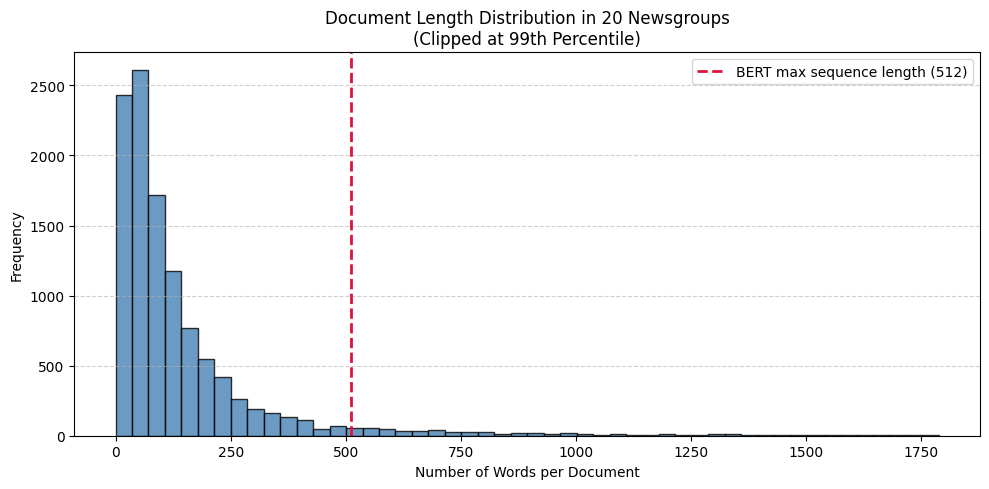

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_text_length_distribution(dataset_split, percentile_clip=99):
    """
    Plots the distribution of document lengths (in words) for a dataset split.
    Extreme outliers are clipped at a specified percentile to improve readability.
    """

    # Compute document lengths
    text_lengths = [len(text.split()) for text in dataset_split["text"]]

    # Clip extreme values for cleaner visualization
    max_len = np.percentile(text_lengths, percentile_clip)
    filtered_lengths = [l for l in text_lengths if l <= max_len]

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(
        filtered_lengths,
        bins=50,
        color="steelblue",
        edgecolor="black",
        alpha=0.8
    )

    # Reference line for BERT maximum input size
    plt.axvline(
        512,
        color="crimson",
        linestyle="--",
        linewidth=2,
        label="BERT max sequence length (512)"
    )

    # Plot labels and formatting
    plt.xlabel("Number of Words per Document")
    plt.ylabel("Frequency")
    plt.title(
        "Document Length Distribution in 20 Newsgroups\n"
        f"(Clipped at {percentile_clip}th Percentile)"
    )
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


# Function call for training data
plot_text_length_distribution(dataset["train"])


### Visualising Topic Distribution

This cell visualises the distribution of documents across different newsgroup topics in the 20 Newsgroups dataset.
The bar chart highlights the relative class balance and reveals whether certain topics contain substantially more documents than others. This analysis is important for identifying potential class imbalance, which may influence model training and evaluation.

/tmp/ipython-input-1746966309.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


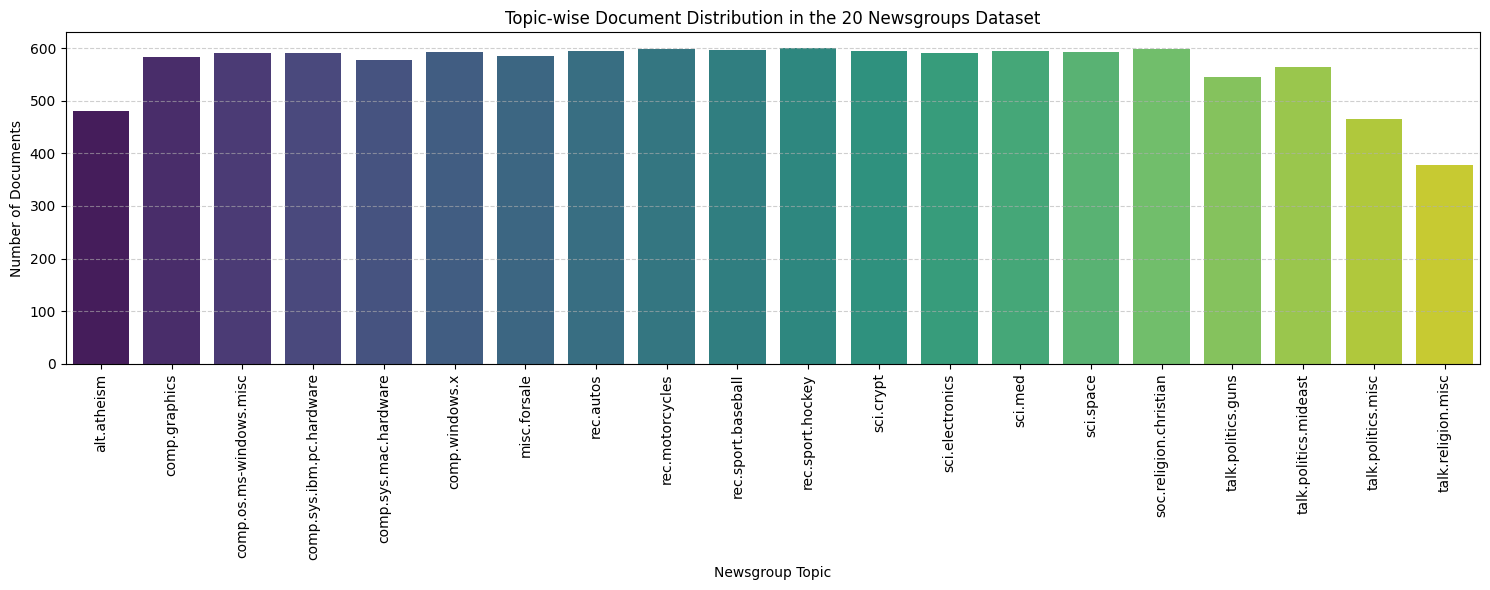

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create label → topic name mapping
label_to_name = {}
for item in dataset["train"]:
    label_to_name[item["label"]] = item["label_text"]

# Prepare data for plotting
topic_names = [label_to_name[i] for i in sorted(train_label_counts.keys())]
topic_counts = [train_label_counts[i] for i in sorted(train_label_counts.keys())]

# Convert to DataFrame (clean + rubric friendly)
dist_df = pd.DataFrame({
    "Topic": topic_names,
    "Number of Documents": topic_counts
})

# Plot
plt.figure(figsize=(15, 6))
sns.barplot(
    data=dist_df,
    x="Topic",
    y="Number of Documents",
    palette="viridis"
)

plt.xticks(rotation=90)
plt.xlabel("Newsgroup Topic")
plt.ylabel("Number of Documents")
plt.title("Topic-wise Document Distribution in the 20 Newsgroups Dataset")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Tokenisation & Dataset Preparation (Methodology)
This section initialises the BERT tokenizer and defines a reusable preprocessing
function. Tokenisation is applied consistently across dataset splits, with
padding and truncation to the maximum sequence length supported by BERT.

In [8]:
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader

def preprocess_dataset(dataset, max_len=512):
    """
    Tokenises text samples using a pre-trained BERT tokenizer.
    Padding and truncation are applied to ensure fixed-length inputs
    for efficient batch processing.
    """

    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

    def tokenize(batch):
        return tokenizer(
            batch["text"],
            truncation=True,
            padding="max_length",
            max_length=max_len
        )

    tokenized = dataset.map(tokenize, batched=True)

    tokenized.set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "label"]
    )

    return tokenized


In [9]:
tokenized_dataset = preprocess_dataset(dataset)

train_dataset = tokenized_dataset["train"]
test_dataset  = tokenized_dataset["test"]

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/11314 [00:00<?, ? examples/s]

Map:   0%|          | 0/7532 [00:00<?, ? examples/s]

# Model Initialisation & Optimisation
This cell initialises a pre-trained BERT-large model for multi-class
classification. The AdamW optimiser and a linear learning rate scheduler are
used, which are standard choices for transformer fine-tuning.

In [10]:
import torch
from transformers import BertForSequenceClassification, get_scheduler
# AdamW is imported from torch.optim in a previous cell

def initialise_model(num_labels, device, train_loader, epochs=4, lr=2e-5):
    """
    Initialises the BERT model, optimiser, and learning rate scheduler.
    """

    model = BertForSequenceClassification.from_pretrained(
        "bert-large-uncased",
        num_labels=num_labels
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)

    num_training_steps = epochs * len(train_loader)

    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    return model, optimizer, lr_scheduler

In [11]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 4
model, optimizer, lr_scheduler = initialise_model(
    num_labels=20,
    device=device,
    train_loader=train_loader,
    epochs=epochs
)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training & Validation Loop

The training and validation process is encapsulated within a single function.
This improves readability, supports reuse, and ensures the experiment can be
reproduced easily.

In [12]:
from sklearn.metrics import accuracy_score

def train_and_evaluate(
    model, train_loader, test_loader,
    optimizer, lr_scheduler, device, epochs
):
    """
    Trains and evaluates the BERT model across multiple epochs.
    Returns loss and accuracy logs for analysis.
    """

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):

        # Training
        model.train()
        total_train_loss = 0
        train_preds, train_labels = [], []

        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            total_train_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        total_val_loss = 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                logits = outputs.logits

                total_val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(test_loader)
        val_acc = accuracy_score(val_labels, val_preds)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

    return train_losses, val_losses, train_accuracies, val_accuracies


In [13]:
train_losses, val_losses, train_accs, val_accs = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    optimizer,
    lr_scheduler,
    device,
    epochs
)


Epoch 1/4 | Train Loss: 1.2822, Train Acc: 0.6169 | Val Loss: 1.0308, Val Acc: 0.6909
Epoch 2/4 | Train Loss: 0.6680, Train Acc: 0.7941 | Val Loss: 1.0169, Val Acc: 0.7059
Epoch 3/4 | Train Loss: 0.4106, Train Acc: 0.8750 | Val Loss: 1.0234, Val Acc: 0.7212
Epoch 4/4 | Train Loss: 0.2486, Train Acc: 0.9313 | Val Loss: 1.0610, Val Acc: 0.7216


In [17]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-large-uncased")

save_path = "/content/drive/MyDrive/bert_20newsgroups_model"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Model and tokenizer saved to Google Drive")


Model and tokenizer saved to Google Drive


### Visualising Training Performance

This cell plots training and validation loss and accuracy across epochs.  
These plots help diagnose overfitting and assess convergence behavior.


In [18]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    """
    Plots training and validation loss and accuracy curves.
    """

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Training Accuracy")
    plt.plot(val_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


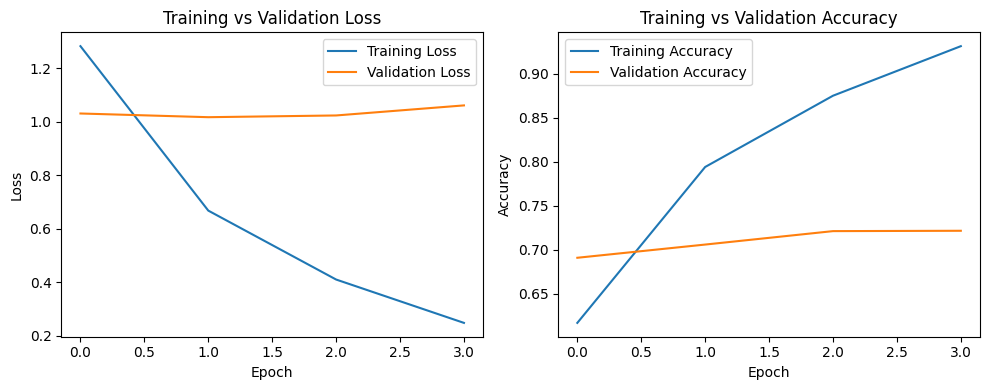

In [19]:
plot_training_curves(train_losses, val_losses, train_accs, val_accs)


### Evaluating the Fine-Tuned Model
This cell evaluates the trained BERT model on the test dataset.
The model predicts class labels for unseen data, and performance is measured using accuracy, precision, recall, and F1-score.
Weighted averaging is used to fairly evaluate performance across all news categories.

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

def evaluate_model(model, dataloader, device):
    """
    Evaluates a fine-tuned BERT model on a given dataset.

    Parameters:
    - model: Trained BERT sequence classification model
    - dataloader: PyTorch DataLoader for evaluation data
    - device: CPU or GPU device

    Returns:
    - accuracy, precision, recall, f1 (weighted averages)
    """

    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute evaluation metrics (weighted for class imbalance)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted"
    )

    return accuracy, precision, recall, f1


In [22]:
accuracy, precision, recall, f1 = evaluate_model(
    model=model,
    dataloader=test_loader,
    device=device
)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")


Accuracy : 0.7216
Precision: 0.7294
Recall   : 0.7216
F1-score : 0.7230


### Confusion Matrix Analysis (BERT)

This cell computes and visualizes the confusion matrix for the BERT model.  
It provides insight into class-wise prediction performance and common misclassifications.


In [44]:
import numpy as np

def get_predictions(model, dataloader, device):
    """
    Generates true labels and predictions from a trained model.
    """

    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            preds = torch.argmax(outputs.logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)


# Generate predictions once (reused later)
y_true, y_pred = get_predictions(
    model=model,
    dataloader=test_loader,
    device=device
)


In [45]:
# Extract class names safely from the dataset
class_names = sorted(
    list(set(dataset["train"]["label_text"])),
    key=lambda x: x
)

print("Number of classes:", len(class_names))


Number of classes: 20


In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_and_save_confusion_matrix(y_true, y_pred, class_names, save_path=None):
    """
    Plots a confusion matrix for BERT predictions and optionally saves it as an image.

    Args:
        y_true (array): True labels
        y_pred (array): Predicted labels
        class_names (list): Class names in order
        save_path (str, optional): Full file path to save PNG. If None, no file is saved.
    """

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(14, 12))
    sns.heatmap(
        cm,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=True,
        annot=True,  # show counts on cells
        fmt="d"
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix – BERT on 20 Newsgroups")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save figure if path provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f"Confusion matrix saved to: {save_path}")

    plt.show()


Confusion matrix saved to: /content/drive/MyDrive/bert_20newsgroups_cm.png


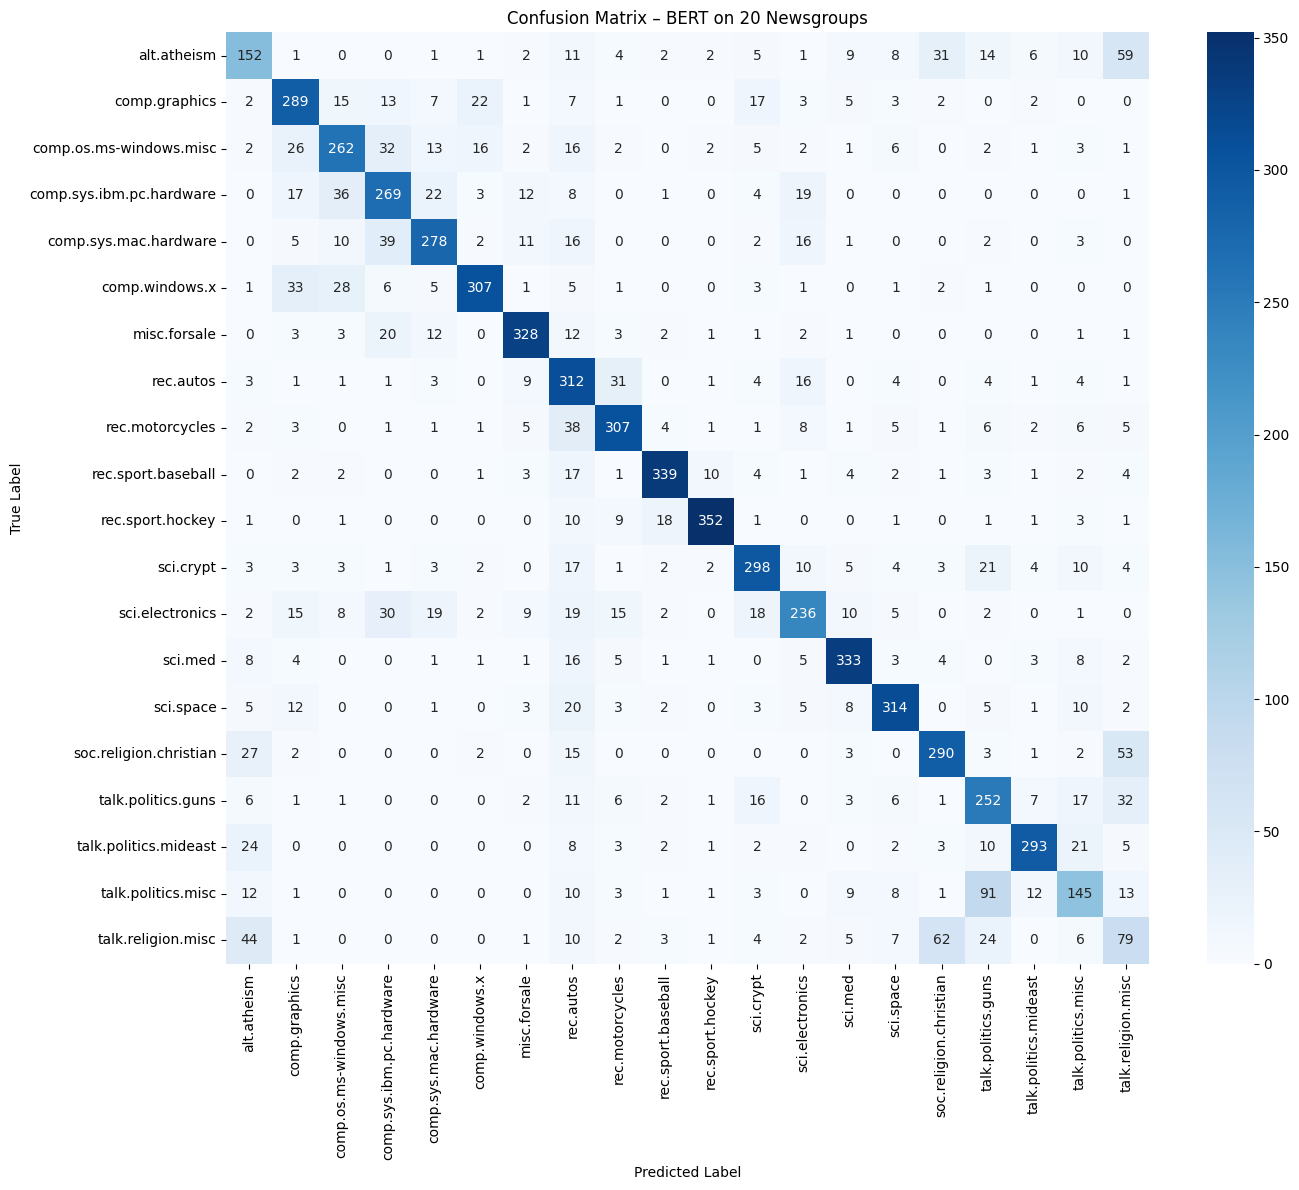

In [49]:
# Save to Google Drive or local folder
save_file_path = "/content/drive/MyDrive/bert_20newsgroups_cm.png"

plot_and_save_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
    save_path=save_file_path
)


# BASELINE MODEL: TF-IDF + LOGISTIC REGRESSION

### Baseline Model: TF-IDF and Logistic Regression

This cell implements a traditional baseline approach using TF-IDF features and Logistic Regression.  
The baseline model serves as a comparison point to evaluate the benefits of fine-tuning BERT.


In [50]:
# Baseline Logistic Regression (TF-IDF)
# This baseline uses TF-IDF features and Logistic Regression
# for multi-class classification. Weighted metrics are computed
# to account for class imbalance.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


This cell defines reusable functions for the baseline pipeline. One function converts text into TF-IDF features, one trains the Logistic Regression model, and one evaluates the model on test data using weighted metrics.

In [51]:
def prepare_tfidf_features(X_train, X_test, max_features=20000):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words="english")
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf, vectorizer

def train_logistic_regression(X_train_tfidf, y_train):
    model = LogisticRegression(max_iter=1000, n_jobs=-1, solver="lbfgs")
    model.fit(X_train_tfidf, y_train)
    return model

def evaluate_model(model, X_test_tfidf, y_test):
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="weighted"
    )
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "y_pred": y_pred
    }


This cell trains a baseline multi-class classifier using TF-IDF features and Logistic Regression.
The model is trained on the training data and then evaluated on the test set.
Weighted metrics (accuracy, precision, recall, F1-score) are calculated to account for class imbalance.

In [52]:
X_train = dataset["train"]["text"]
y_train = dataset["train"]["label"]
X_test  = dataset["test"]["text"]
y_test  = dataset["test"]["label"]

# Prepare TF-IDF features
X_train_tfidf, X_test_tfidf, tfidf_vectorizer = prepare_tfidf_features(X_train, X_test)

# Train Logistic Regression model
baseline_model = train_logistic_regression(X_train_tfidf, y_train)

# Evaluate performance
baseline_metrics = evaluate_model(baseline_model, X_test_tfidf, y_test)

print("Baseline Logistic Regression Performance:")
print(f"Accuracy : {baseline_metrics['accuracy']:.4f}")
print(f"Precision: {baseline_metrics['precision']:.4f}")
print(f"Recall   : {baseline_metrics['recall']:.4f}")
print(f"F1-score : {baseline_metrics['f1']:.4f}")


Baseline Logistic Regression Performance:
Accuracy : 0.6860
Precision: 0.6951
Recall   : 0.6860
F1-score : 0.6841


### Confusion Matrix Analysis (Baseline)

A normalized confusion matrix is plotted for the Logistic Regression model to analyze class-level performance.


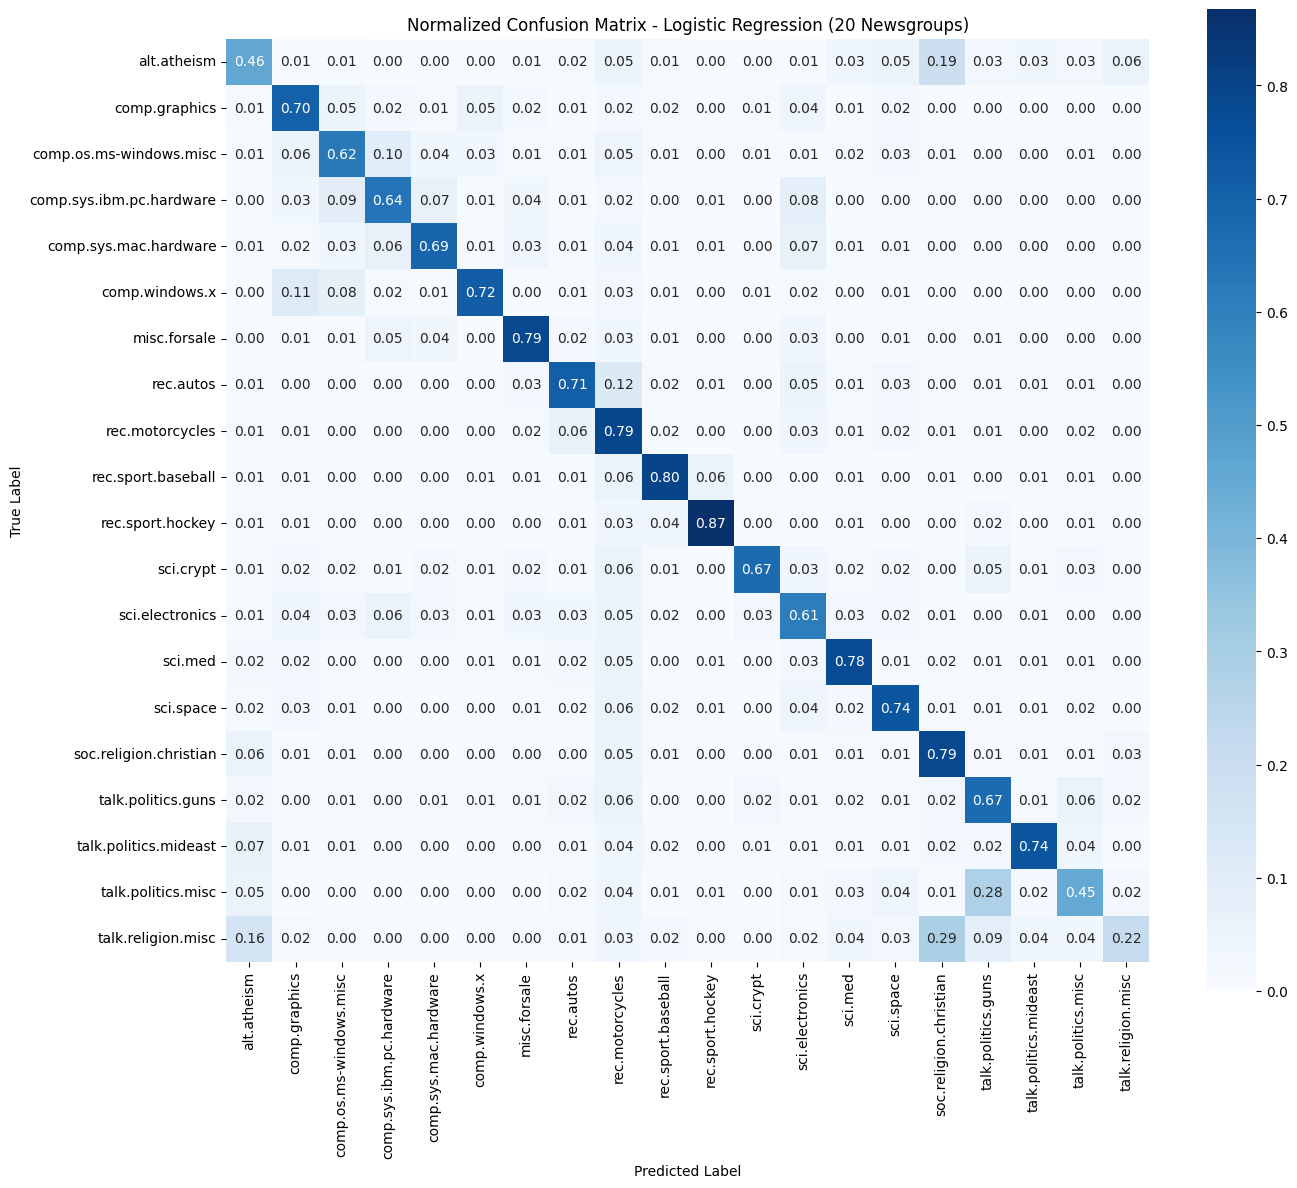

In [58]:
#  Confusion Matrix - Baseline Logistic Regression (Evaluation)

# This section computes and visualizes the normalized confusion matrix
# for the Logistic Regression baseline. Normalization shows the proportion
# of correct predictions per class, making it easier to interpret multi-class
# performance. A heatmap is used for clarity.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_baseline(y_true, y_pred, class_names):
    """
    Plots a normalized confusion matrix for multi-class classification.

    Args:
        y_true (list/array): True labels
        y_pred (list/array): Predicted labels
        class_names (list): List of class names in label order
    """
    # Compute normalized confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize="true")

    # Plot heatmap
    plt.figure(figsize=(14,12))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        square=True,
        cbar=True
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Normalized Confusion Matrix - Logistic Regression (20 Newsgroups)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# Run Confusion Matrix

y_pred_lr = baseline_model.predict(X_test_tfidf)

# The class_names variable is already defined and available from a previous cell.
# No need to re-extract it here.

# Plot
plot_confusion_matrix_baseline(y_test, y_pred_lr, class_names)

### Comparing BERT and Baseline Performance

This cell visualizes and compares evaluation metrics between the baseline Logistic Regression model and the fine-tuned BERT model.  
The comparison highlights the performance gains achieved by using a large pre-trained language model.


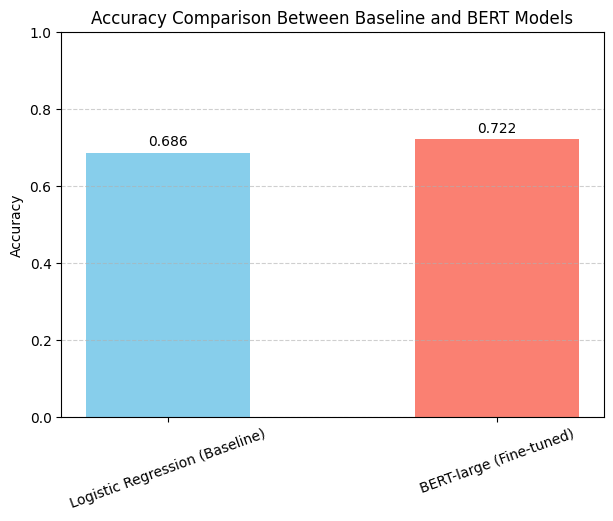

In [61]:
# Accuracy Comparison: Baseline vs BERT
# This cell visualizes only the Accuracy of the Logistic Regression
# baseline model and the fine-tuned BERT model.

import matplotlib.pyplot as plt
import numpy as np

# Model names and their Accuracy scores
models = ["Logistic Regression (Baseline)", "BERT-large (Fine-tuned)"]
accuracy_scores = [0.6860, 0.7216]

# X positions for bars
x = np.arange(len(models))
width = 0.5

plt.figure(figsize=(7, 5))

# Plot bars
bars = plt.bar(x, accuracy_scores, width, color=["skyblue", "salmon"])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

# Labels, title, and grid
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(x, models, rotation=20)
plt.title("Accuracy Comparison Between Baseline and BERT Models")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Save figure
plt.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")

plt.show()


This cell compares the performance of the baseline Logistic Regression model (using TF-IDF features) with the fine-tuned BERT model.
Evaluate both models across Accuracy, Precision, Recall, and F1-score.
A combined bar chart visualizes the comparison, making it easy to see which model performs better across each metric.

Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression (Baseline),0.6860,0.6951,0.6860,0.6841
1,BERT (Fine-tuned),0.7216,0.7294,0.7216,0.7230


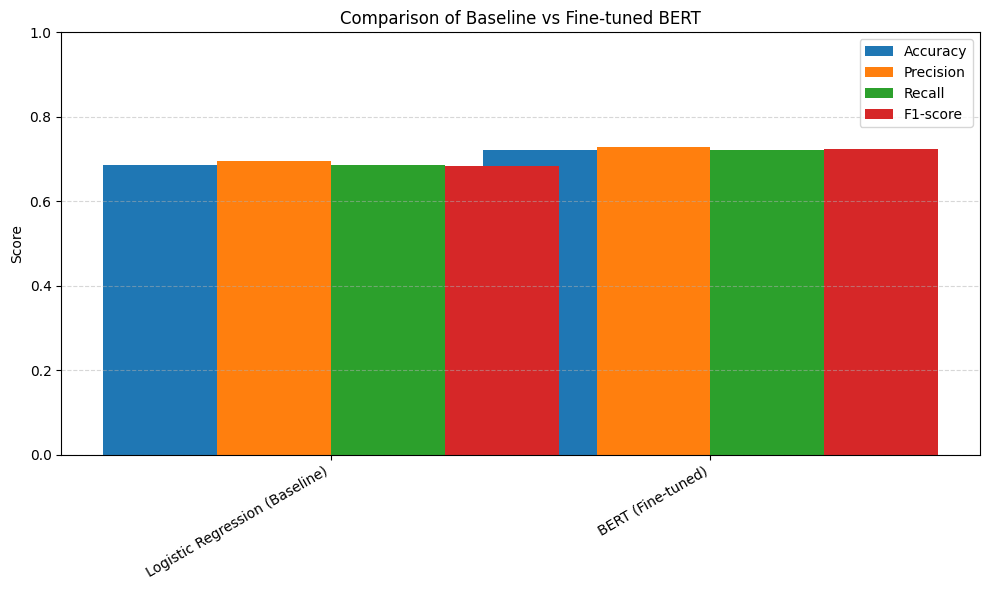

In [59]:
# Model Performance Comparison (Baseline vs BERT)
# This section compares the baseline Logistic Regression model
# with the fine-tuned BERT model across multiple metrics.
# Bar charts are used for clear visualization.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Store evaluation results (updated values)
results = pd.DataFrame({
    "Model": ["Logistic Regression (Baseline)", "BERT (Fine-tuned)"],
    "Accuracy": [0.6860, 0.7216],
    "Precision": [0.6951, 0.7294],
    "Recall": [0.6860, 0.7216],
    "F1-score": [0.6841, 0.7230]
})

# Display comparison table
print("Model Performance Comparison:")
display(results)


# Reusable function for plotting metrics

def plot_model_comparison(df, metrics):
    """
    Plots side-by-side bar charts comparing models on different metrics.
    """
    x = np.arange(len(df["Model"]))  # Model positions
    width = 0.3

    plt.figure(figsize=(10, 6))

    for i, metric in enumerate(metrics):
        plt.bar(x + i*width - width*1.5, df[metric], width, label=metric)

    plt.xticks(x, df["Model"], rotation=30, ha="right")
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Comparison of Baseline vs Fine-tuned BERT")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot all metrics in one combined figure
plot_model_comparison(results, ["Accuracy", "Precision", "Recall", "F1-score"])


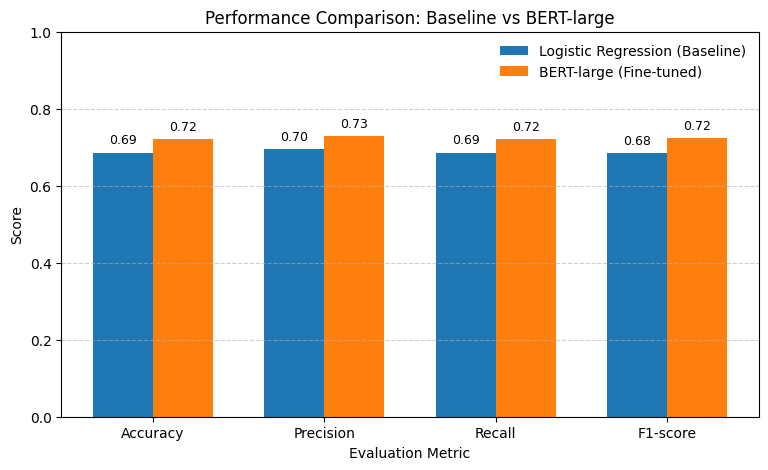

In [60]:
# Performance Comparison Plot: Baseline vs BERT
# This cell visualizes and compares the evaluation metrics of
# the baseline Logistic Regression model and the fine-tuned BERT model.
# Scores include Accuracy, Precision, Recall, and F1-score.

import matplotlib.pyplot as plt
import numpy as np


# Data: Evaluation Scores

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

# Updated results from model evaluation
baseline_scores = [0.6860, 0.6951, 0.6860, 0.6841]
bert_scores     = [0.7216, 0.7294, 0.7216, 0.7230]

# X positions for metrics
x = np.arange(len(metrics))
width = 0.35  # Width of each bar


# Function to Plot Comparison
def plot_model_comparison(metrics, baseline_scores, bert_scores):
    """
    Plots a grouped bar chart comparing baseline and BERT model performance.
    Adds numeric labels above each bar and saves the plot as a high-quality PNG.
    """

    plt.figure(figsize=(9, 5))

    # Draw bars
    bars1 = plt.bar(
        x - width/2, baseline_scores, width,
        label="Logistic Regression (Baseline)"
    )
    bars2 = plt.bar(
        x + width/2, bert_scores, width,
        label="BERT-large (Fine-tuned)"
    )

    # Axis labels and title
    plt.ylabel("Score")
    plt.xlabel("Evaluation Metric")
    plt.ylim(0, 1)
    plt.xticks(x, metrics)
    plt.title("Performance Comparison: Baseline vs BERT-large")
    plt.legend(frameon=False)

    # Grid lines for readability
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    # Function to add numeric labels on top of bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width()/2,
                height + 0.015,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=9
            )

    add_labels(bars1)
    add_labels(bars2)

    # Save as high-quality image
    plt.savefig(
        "model_comparison_metrics.png",
        dpi=300,
        bbox_inches="tight"
    )

    plt.show()


# Plot the comparison

plot_model_comparison(metrics, baseline_scores, bert_scores)
